# Model Results Page
## Modules used were influenced by an exploration kernel on the kaggle competition dashboard:
https://www.kaggle.com/allunia/protein-atlas-exploration-and-baseline

In [152]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
sns.set()

# Load Data
train_path = 'train/'
train_labels = pd.read_csv('./train.csv')
labels_path = './train.csv'




In [153]:
train_labels.shape[0]

31072

In [154]:
splitter = RepeatedKFold(n_splits=3, n_repeats=1, random_state=0)

In [155]:
partitions = []

for train_idx, test_idx in splitter.split(train_labels.index.values):
    partition = {}
    partition["train"] = train_labels.Id.values[train_idx]
    partition["validation"] = train_labels.Id.values[test_idx]
    partitions.append(partition)
#     print("TRAIN:", train_idx, "TEST:", test_idx)
#     print("TRAIN:", len(train_idx), "TEST:", len(test_idx))

In [156]:
label_names = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

reverse_train_labels = dict((v,k) for k,v in label_names.items())

def fill_targets(row):
    row.Target = np.array(row.Target.split(" ")).astype(np.int)
    for num in row.Target:
        name = label_names[int(num)]
        row.loc[name] = 1
    return row

In [157]:
train_labels = train_labels.apply(fill_targets, axis=1)
train_labels["number_of_targets"] = train_labels.drop(["Id", "Target"],axis=1).sum(axis=1)

In [158]:
baseline_proba_predictions = pd.read_csv("./baseline_predictions.csv", index_col=0)
validation_labels = train_labels.loc[train_labels.Id.isin(partition["validation"])]

In [159]:
# print(validation_labels.shape)
# print(baseline_proba_predictions.shape)

In [160]:
proba_predictions = baseline_proba_predictions.values

In [161]:
hot_values = validation_labels.drop(["Id", "Target","number_of_targets"], axis=1).fillna(0).values.flatten()
one_hot = (hot_values.sum()) / hot_values.shape[0] * 100
zero_hot = (hot_values.shape[0] - hot_values.sum()) / hot_values.shape[0] * 100

Text(0, 0.5, 'Percentage')

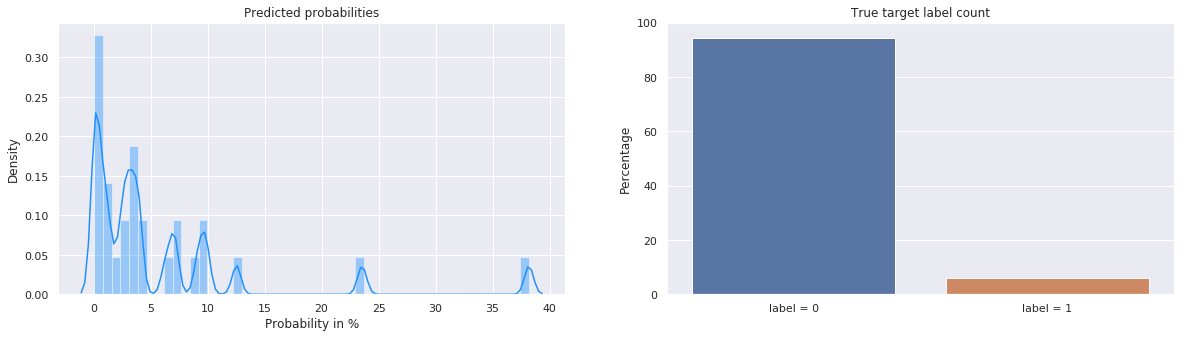

In [162]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.distplot(proba_predictions.flatten() * 100, color="DodgerBlue", ax=ax[0])
ax[0].set_xlabel("Probability in %")
ax[0].set_ylabel("Density")
ax[0].set_title("Predicted probabilities")
sns.barplot(x=["label = 0", "label = 1"], y=[zero_hot, one_hot], ax=ax[1])
ax[1].set_ylim([0,100])
ax[1].set_title("True target label count")
ax[1].set_ylabel("Percentage")

The above graph shows that our current model is not as certain when it predicts the presence of a target protein. there are higher probability densities closer to zero, but we do see peaks above 20 and above 40. We think that our current model is very good at one set of labels and quite poor at others due to their frequency of occurrence in the dataset.

Text(0.5, 1.0, 'Standard deviation of predicted probability per class over all samples')

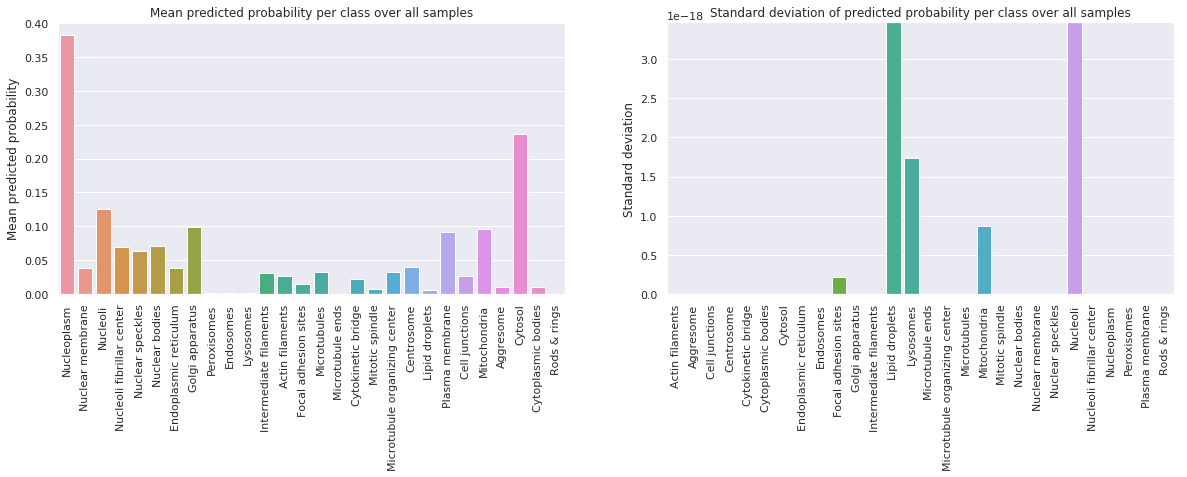

In [163]:
mean_predictions = np.mean(proba_predictions, axis=0)
std_predictions = np.std(proba_predictions, axis=0)
mean_targets = validation_labels.drop(["Id", "Target", "number_of_targets"], axis=1).fillna(0).mean()

labels = validation_labels.drop(["Id", "Target", "number_of_targets"], axis=1).columns.values
baselabels = baseline_proba_predictions.columns.values

fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.barplot(x=baselabels,
            y=mean_predictions,
            ax=ax[0])
ax[0].set_xticklabels(labels=baselabels,
                      rotation=90)
ax[0].set_ylabel("Mean predicted probability")
ax[0].set_title("Mean predicted probability per class over all samples")
sns.barplot(x=labels,
           y=std_predictions,
           ax=ax[1])
ax[1].set_xticklabels(labels=labels,
                      rotation=90)
ax[1].set_ylabel("Standard deviation")
ax[1].set_title("Standard deviation of predicted probability per class over all samples")

These graphs show our mean predicted probability across different labels. We see that we have a very high probability for Actin Filaments and almost none for Endosomes. We compared our results to other kernels on the leaderboard and it appears we have a similar distribution, but favor Aggresomes and a few others disproportionately. Furthermore, we have very high standard deviations of our predicted probabilities for a few labels and almost none for the others. This is an issue we are investigating, but we suspect it has to do with our feature augmentation.

Text(0.5, 1.0, 'Percentage of hot counts (ones) per target class')

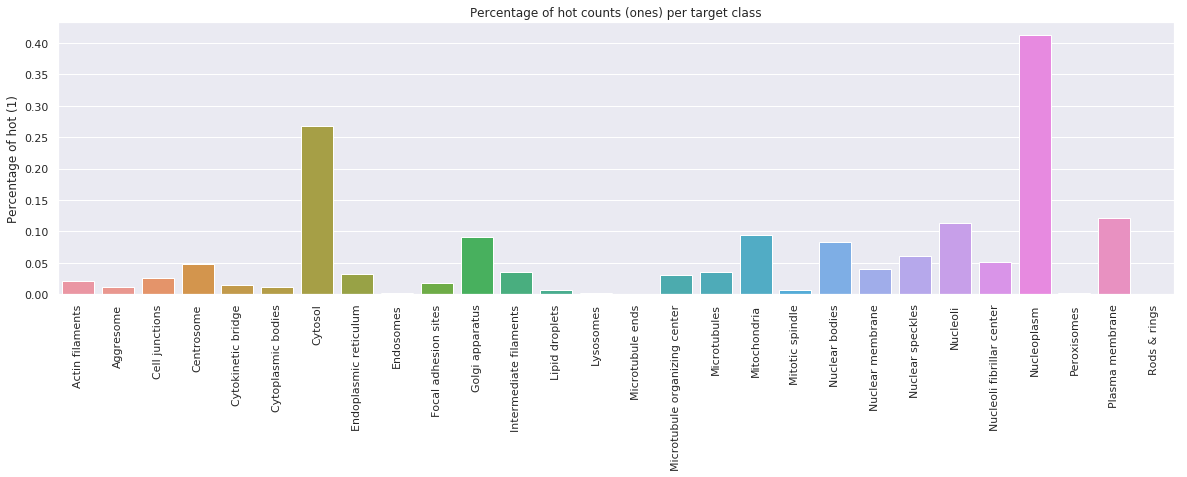

In [164]:
fig, ax = plt.subplots(1,1,figsize=(20,5))
sns.barplot(x=labels, y=mean_targets.values, ax=ax)
ax.set_xticklabels(labels=labels,
                      rotation=90)
ax.set_ylabel("Percentage of hot (1)")
ax.set_title("Percentage of hot counts (ones) per target class")

We can see that the probability distribution for our labels is quite similar to the target for the validation set.
However, it is concerning that the probabilities are equal for all images.
In the next graph, we choose a random feature and try to see its probability. We saw that we were predicting the same probability across all images for a given label. This is a huge issue that we are working to fix.

(0, 1)

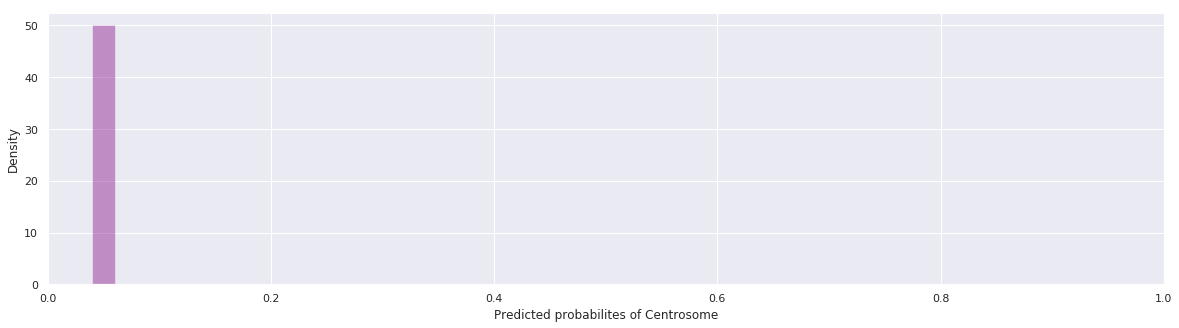

In [165]:
feature = "Centrosome"
plt.figure(figsize=(20,5))
sns.distplot(baseline_proba_predictions[feature].values[0:-10], color="Purple")
plt.xlabel("Predicted probabilites of {}".format(feature))
plt.ylabel("Density")
plt.xlim([0,1])

In [169]:
mean_targets
# validation_labels.columns

Actin filaments                  0.021531
Aggresome                        0.010621
Cell junctions                   0.026359
Centrosome                       0.047408
Cytokinetic bridge               0.015062
Cytoplasmic bodies               0.011393
Cytosol                          0.267066
Endoplasmic reticulum            0.031380
Endosomes                        0.001641
Focal adhesion sites             0.017283
Golgi apparatus                  0.091146
Intermediate filaments           0.035338
Lipid droplets                   0.005793
Lysosomes                        0.001159
Microtubule ends                 0.000579
Microtubule organizing center    0.030511
Microtubules                     0.035242
Mitochondria                     0.093367
Mitotic spindle                  0.005986
Nuclear bodies                   0.082746
Nuclear membrane                 0.039201
Nuclear speckles                 0.060346
Nucleoli                         0.112871
Nucleoli fibrillar center        0

In [167]:
baseline_proba_predictions.tail()

,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,Peroxisomes,Endosomes,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
10352,0.382029,0.038273,0.125248,0.070071,0.063186,0.071039,0.038788,0.09907,0.00126,0.001582,...,0.032417,0.039963,0.005285,0.091363,0.026389,0.096459,0.010066,0.235548,0.010096,0.000585
10353,0.382029,0.038273,0.125248,0.070071,0.063186,0.071039,0.038788,0.09907,0.00126,0.001582,...,0.032417,0.039963,0.005285,0.091363,0.026389,0.096459,0.010066,0.235548,0.010096,0.000585
10354,0.382029,0.038273,0.125248,0.070071,0.063186,0.071039,0.038788,0.09907,0.00126,0.001582,...,0.032417,0.039963,0.005285,0.091363,0.026389,0.096459,0.010066,0.235548,0.010096,0.000585
10355,0.382029,0.038273,0.125248,0.070071,0.063186,0.071039,0.038788,0.09907,0.00126,0.001582,...,0.032417,0.039963,0.005285,0.091363,0.026389,0.096459,0.010066,0.235548,0.010096,0.000585
10356,0.382029,0.038273,0.125248,0.070071,0.063186,0.071039,0.038788,0.09907,0.00126,0.001582,...,0.032417,0.039963,0.005285,0.091363,0.026389,0.096459,0.010066,0.235548,0.010096,0.000585
